In [48]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pylab
import mysql.connector as sql
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction import FeatureHasher
from sklearn.pipeline import Pipeline
from feature_engine.categorical_encoders import MeanCategoricalEncoder, OneHotCategoricalEncoder
from feature_engine import missing_data_imputers as mdi
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost import plot_tree
import details


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format

In [ ]:
#Use this code to store the best_params so that you don't have to rerun the hyperoptimization function
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
#Load the data from mysql
#password = details.db_password
#db_connection = sql.connect(host='Samuels-MacBook-Air.local', database='realestate_AVM',
#                            user='root', password=password)

#df = pd.read_sql('SELECT * FROM properties;', con=db_connection)
#df.head()

In [70]:
raw_data = pd.read_csv('Data/house_data_details_eda.csv')
df = raw_data.copy()
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df.longitude, df.latitude)])
gdf.crs = {'init': 'epsg:4326'}

In [ ]:
pipeline = Pipeline([
    ('')
])

In [71]:
gdf = gdf[['latitude', 'longitude', 'geometry', 'bedrooms', 'bathrooms', 'home_size', 'lot_size', 'sale_price']]
gdf.head()

,latitude,longitude,geometry,bedrooms,bathrooms,home_size,lot_size,sale_price
0,33.85415,-118.38617,POINT (-118.38617 33.85415),4.00000,3.00000,3434.00000,6636.00000,1573.21327
1,34.11858,-118.13477,POINT (-118.13477 34.11858),3.00000,2.00000,2465.00000,11659.00000,1404.27917
2,34.00160,-117.80524,POINT (-117.80524 34.00160),4.00000,2.00000,1771.00000,8291.00000,900.00000
3,34.17802,-118.14649,POINT (-118.14649 34.17802),3.00000,2.00000,1846.00000,5040.00000,954.98691
4,34.16851,-118.06239,POINT (-118.06239 34.16851),2.00000,2.00000,1334.00000,8314.00000,954.20124


In [72]:
#Split the dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(gdf.drop(['sale_price'], axis=1), gdf['sale_price'], test_size=.1, random_state=24)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2, random_state=24)

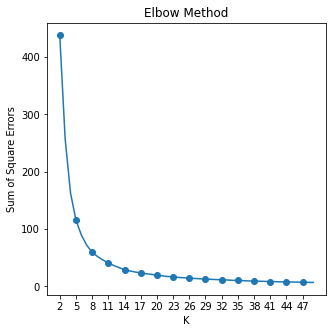

In [5]:
#Cluster the properties by location
ssd = []

for i in range(2,50):
    
    kmeans = KMeans(n_clusters=i, init ='k-means++')
    kmeans.fit_predict(x_train[['latitude', 'longitude']])
    ssd.append(ssd.append(kmeans.inertia_))
    
ssd = ssd[::2]


#Elbow method to determine the optimal number for k
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(list(range(2,50)), ssd, marker='o', markevery=3)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('Sum of Square Errors')
ax.set(xticks=range(2,50,3));

In [73]:
#9 seems like the optimal number of clusters
kmeans = KMeans(n_clusters=9, init='k-means++')
x_train['geolocation_cluster'] = kmeans.fit_predict(x_train[['latitude', 'longitude']])
x_val['geolocation_cluster'] = kmeans.predict(x_val[['latitude', 'longitude']])
x_test['geolocation_cluster'] = kmeans.predict(x_test[['latitude', 'longitude']])

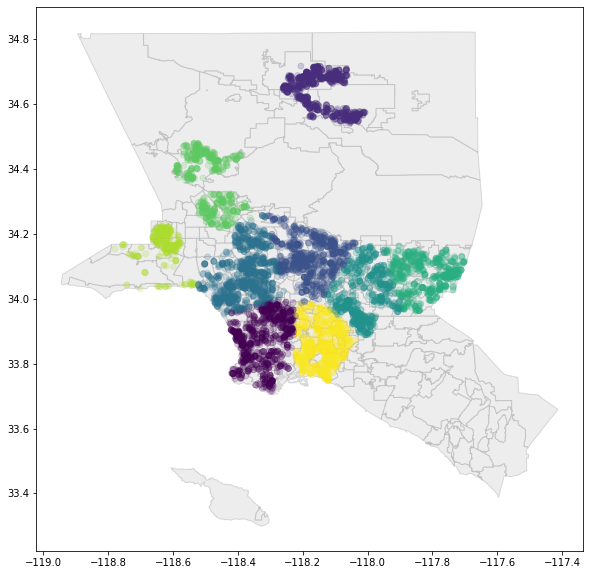

In [7]:
#Plot the data point on a map of Los Angeles
fig, ax = plt.subplots(figsize=(10,10))

la_full = gpd.read_file('LACounty/l.a. county neighborhood (v6).shp')
la_full.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', aspect=1,zorder=1)

#Conver x_train df into geopandas df so that we can visualize it
temp_plot = gpd.GeoDataFrame(x_train.copy(), geometry=[Point(xy) for xy in zip(x_train.longitude, x_train.latitude)])
temp_plot.plot(ax=ax, aspect=1, c=temp_plot['geolocation_cluster'], alpha=0.2, linewidth=0.8, zorder=2);

In [74]:
#Find the distance between each point and each observation in order to smooth out prices that lie on the border of clusters
kc = kmeans.cluster_centers_

def calculate_distances(df, kc):
    for i in range(len(kc)):
        df['distance_' + str(i)] = np.sqrt((df.latitude-kc[i][0])**2+(df.longitude-kc[i][1])**2)
    return df
    
x_train = calculate_distances(x_train, kc)
x_val = calculate_distances(x_val, kc)
x_test = calculate_distances(x_test, kc)

#Save the kmeans object
save_obj(kmeans, 'kmeans_neighborhood')
    
#Drop the latitude and longitude
x_train.drop(['latitude', 'longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)
x_val.drop(['latitude', 'longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)
x_test.drop(['latitude', 'longitude', 'geolocation_cluster', 'geometry'], axis=1, inplace=True)

In [21]:
#Dummy encode the categorical variables
ohe_encoder = OneHotCategoricalEncoder(variables=['crime_index', 'school_quality'])

ohe_encoder.fit(x_train)

x_train = ohe_encoder.transform(x_train)
x_val = ohe_encoder.transform(x_val)
x_test = ohe_encoder.transform(x_test)

In [22]:
from category_encoders.hashing import HashingEncoder

he = HashingEncoder(cols=['zoning'], n_components=8).fit(x_train, y_train)


x_train = he.transform(x_train)
x_val = he.transform(x_val)
x_test = he.transform(x_test)

#The hasher is going to reset the index so we need to do the same for y_train
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### XGBoost Model

In [76]:
#Optimize the objective function with hyperopt for xgboost


#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Definte the search space
space = {
            'base_score' : [.5, .15, .25, .5, .75, .85, .95, .975, .9825, .999],
            'booster' : ['gbtree', 'dart'],
            'importance_type' : ['weight', 'gain', 'cover', 'total_gain', 'total_cover'],
            'learning_rate' : [None, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
            #'max_delta_step' : [None, 1, 2, 3, 4, 5,10,15,20,25,30,35,40,45,50,55,60],
            'num_parallel_tree' : [None, 1, 2, 3, 4, 5],
    
         }

#Objective function
#cv = KFold(n_splits=8, random_state=24, shuffle=True)

def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
   
    regressor = xgb.XGBRegressor(random_state=24,
                                 base_score= params['base_score'],
                                 booster= params['booster'], 
                                 colsample_bylevel= params['colsample_bylevel'], 
                                 colsample_bynode= params['colsample_bynode'],
                                 colsample_bytree= params['colsample_bytree'], 
                                 gamma= params['gamma'], 
                                 importance_type= params['importance_type'],
                                 learning_rate= params['learning_rate'],
                                 #max_delta_step= params['max_delta_step'], 
                                 max_depth= depth, 
                                 min_child_weight= params['min_child_weight'],
                                 n_estimators=est, 
                                 num_parallel_tree= params['num_parallel_tree'], 
                                 reg_lambda= params['reg_lambda'])
   
    regressor.fit(x_train, y_train)
    
    test_predictions = regressor.predict(x_val)**2
    y_test_transformed = y_val**2  
    
    return mean_absolute_percentage_error(y_test_transformed, test_predictions)
    #return -cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_error').mean()

#Define the search space
param_space = { 
                'base_score' : hp.choice('base_score', space.get('base_score')),
                'booster': hp.choice('booster', space.get('booster')),
                'colsample_bylevel': hp.uniform('colsample_bylevel', 0, 1),
                'colsample_bynode': hp.uniform('colsample_bynode', 0, 1),
                'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
                'gamma': hp.uniform('gamma',1,15),
                'importance_type': hp.choice('importance_type', space.get('importance_type')),
                'learning_rate': hp.choice('learning_rate', space.get('learning_rate')),
                #'max_delta_step': hp.quniform('n_estimators', 25,1000,1),
                'max_depth': hp.quniform('max_depth',1,10,1),
                'min_child_weight': hp.uniform('min_child_weight', 1, 100),
                'n_estimators': hp.quniform('n_estimators', 25,1000,1),
                'num_parallel_tree': hp.choice('num_parallel_tree', space.get('num_parallel_tree')),
                'reg_lambda': hp.uniform('reg_lambda',1,15)
            }

best = 1000

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=25, trials=trials)
print ('best:')
print (best_params)

new best:                                             
115.71860442156148                                    
{'base_score': 0.25, 'booster': 'gbtree', 'colsample_bylevel': 0.47733510770026377, 'colsample_bynode': 0.2154886022314254, 'colsample_bytree': 0.8067747295777653, 'gamma': 2.909577407891306, 'importance_type': 'total_cover', 'learning_rate': 0.2, 'max_depth': 2.0, 'min_child_weight': 58.974428242248884, 'n_estimators': 61.0, 'num_parallel_tree': 4, 'reg_lambda': 12.695647699799423}
new best:                                                                       
102.13376272828876                                                              
{'base_score': 0.95, 'booster': 'dart', 'colsample_bylevel': 0.7491117856338327, 'colsample_bynode': 0.06007562574853609, 'colsample_bytree': 0.33283114942312253, 'gamma': 4.044488365561444, 'importance_type': 'cover', 'learning_rate': 0.1, 'max_depth': 7.0, 'min_child_weight': 36.988192455385594, 'n_estimators': 145.0, 'num_parallel_tree':

In [77]:
#Create a function that can transform the parameters into a readable object for the XGBRegressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    
    for param in space:
        temp[param] = space.get(param)[best.get(param)]
        
    return temp


best_params = return_proper_params(best_params)
best_params

{'base_score': 0.15,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9921277759419532,
 'colsample_bynode': 0.4064190299142868,
 'colsample_bytree': 0.5656804993073012,
 'gamma': 5.042866749787769,
 'importance_type': 'weight',
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_child_weight': 1.3121993364350795,
 'n_estimators': 618,
 'num_parallel_tree': 1,
 'reg_lambda': 3.958765159217636}

In [79]:
#save_obj(best_params, 'best_params_xgb_2')
best_params = load_obj('best_params_xgb_2')
best_params

{'base_score': 0.15,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9921277759419532,
 'colsample_bynode': 0.4064190299142868,
 'colsample_bytree': 0.5656804993073012,
 'gamma': 5.042866749787769,
 'importance_type': 'weight',
 'learning_rate': 0.15,
 'max_depth': 8,
 'min_child_weight': 1.3121993364350795,
 'n_estimators': 618,
 'num_parallel_tree': 1,
 'reg_lambda': 3.958765159217636}

In [80]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


regressor = xgb.XGBRegressor(random_state=24,
                             base_score= best_params['base_score'],
                             booster= best_params['booster'],
                             colsample_bylevel= best_params['colsample_bylevel'], 
                             colsample_bynode= best_params['colsample_bynode'],
                             colsample_bytree= best_params['colsample_bytree'],
                             gamma= best_params['gamma'],
                             importance_type= best_params['importance_type'],
                             learning_rate= best_params['learning_rate'],
                             #max_delta_step= 50,#best_params['max_delta_step']) 
                             max_depth= best_params['max_depth'],
                             min_child_weight= best_params['min_child_weight'],
                             n_estimators= best_params['n_estimators'], 
                             num_parallel_tree= best_params['num_parallel_tree'], 
                             reg_lambda= best_params['reg_lambda'])

regressor.fit(x_train, y_train)

# Need to back transform the target variable
test_predictions = regressor.predict(x_test)**2
y_test_transformed = y_test**2


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'XGBoost mape on testing set: {score}%')

XGBoost mape on testing set: 84.751%


In [82]:
#MAPE for the train set
train_predictions = regressor.predict(x_train)**2
y_train_transformed = y_train**2

score = np.round(mean_absolute_percentage_error(y_train_transformed, train_predictions),3)
print(f'XGBoost mape on training set: {score}%')

XGBoost mape on training set: 35.748%


In [83]:
#Save the model
pickle.dump(regressor, open("model.pickle.dat", "wb"))
# load model from file
loaded_model = pickle.load(open("model.pickle.dat", "rb"))

In [ ]:
# Test the loaded model
# load model from file
loaded_model = pickle.load(open("model.pickle.dat", "rb"))

test_predictions = loaded_model.predict(x_test)**2
y_test_transformed = y_test**2


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'XGBoost mape on testing set: {score}%')

In [86]:
neighborhoods = pd.read_csv('Data/Neighborhoods_final.csv')
#load the model
loaded_model = pickle.load(open("model.pickle.dat", "rb"))
# This  is the geocoordinates of the neighborhood selected
map_filter = neighborhoods.loc[neighborhoods['neighborhood']
                               == 'Culver City', ['longitude', 'latitude']]

In [87]:
map_filter

,longitude,latitude
46,34.00590,-118.40902


In [16]:
#Let's examine the residuals
residuals = x_train.copy()
residuals['sale_price'] = y_train_transformed
residuals['predicted_sale_price'] = train_predictions
residuals['residuals'] = y_train_transformed - train_predictions
sorted_df = residuals.sort_values(by='residuals', ascending=False)
sorted_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,home_size,lot_size,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,cpi,age,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,crime_index_Slightly High,crime_index_Low,crime_index_Moderate,crime_index_Very Low,crime_index_High,crime_index_Moderately High,school_quality_Average,school_quality_Excellent,school_quality_Poor,school_quality_Above Average,sale_price,predicted_sale_price,residuals
5762,0,0,1,0,0,0,0,0,1787.00000,5707.00000,2,2,1,3.00000,3.00000,166.20000,16.00000,0.23859,0.41613,0.56291,0.71569,0.85981,0.40092,0.60202,0.78226,0.06482,0,0,0,0,0,1,0,0,0,1,3980000.00000,1585592.87500,2394407.12500
5920,0,0,0,0,1,0,0,0,2013.00000,8154.00000,1,3,1,3.00000,2.00000,184.60000,63.00000,0.32551,0.12316,0.31339,0.47583,0.33813,0.36654,0.14427,0.26052,0.47926,0,1,0,0,0,0,0,1,0,0,5850000.00000,3606891.00000,2243109.00000
528,0,0,1,0,0,0,0,0,2735.00000,6356.00000,3,5,1,3.00000,3.00000,177.70000,74.00000,0.31117,0.10923,0.30371,0.48336,0.34756,0.35250,0.14257,0.27526,0.46694,0,1,0,0,0,0,0,0,0,1,5790000.00000,3548194.00000,2241806.00000
3713,0,0,1,0,0,0,0,0,1248.00000,8099.00000,6,3,2,3.00000,2.00000,260.30100,66.00000,0.13261,0.29044,0.46556,0.62291,0.73583,0.32496,0.48115,0.65632,0.07246,0,1,0,0,0,0,0,0,0,1,4980000.00000,2999901.00000,1980099.00000
6009,0,0,1,0,0,0,0,0,1206.00000,5979.00000,12,3,1,3.00000,2.00000,260.30100,65.00000,0.08352,0.25052,0.29468,0.72124,0.64080,0.13271,0.37664,0.62632,0.25051,0,0,1,0,0,0,0,0,0,1,5500000.00000,3577351.00000,1922649.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5969,0,0,0,0,0,0,1,0,1240.00000,6165.00000,9,5,1,4.00000,2.00000,189.40000,48.00000,0.06040,0.25899,0.38422,0.66811,0.68975,0.23438,0.42783,0.63952,0.15031,0,0,1,0,0,0,0,0,0,1,570000.00000,1639987.25000,-1069987.25000
3173,0,0,1,0,0,0,0,0,1787.00000,5707.00000,2,2,1,3.00000,3.00000,184.20000,20.00000,0.23859,0.41613,0.56291,0.71569,0.85981,0.40092,0.60202,0.78226,0.06482,0,0,0,0,0,1,0,0,0,1,310000.00000,1390879.00000,-1080879.00000
4104,0,0,0,0,0,0,0,1,2509.00000,9250.00000,3,3,1,4.00000,4.00000,177.50000,7.00000,0.44965,0.24694,0.41144,0.42418,0.28031,0.49007,0.21003,0.13515,0.58866,0,1,0,0,0,0,1,0,0,0,662830.00000,1801503.00000,-1138673.00000
5296,0,0,1,0,0,0,0,0,1787.00000,5707.00000,2,2,1,3.00000,3.00000,166.20000,16.00000,0.23859,0.41613,0.56291,0.71569,0.85981,0.40092,0.60202,0.78226,0.06482,0,0,0,0,0,1,0,0,0,1,398000.00000,1585592.87500,-1187592.87500


<AxesSubplot:>

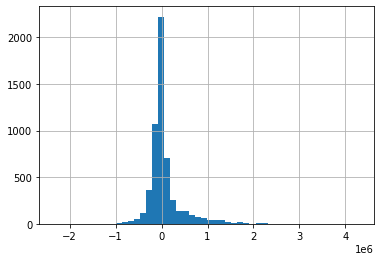

In [43]:
sorted_df['residuals'].hist(bins=50)

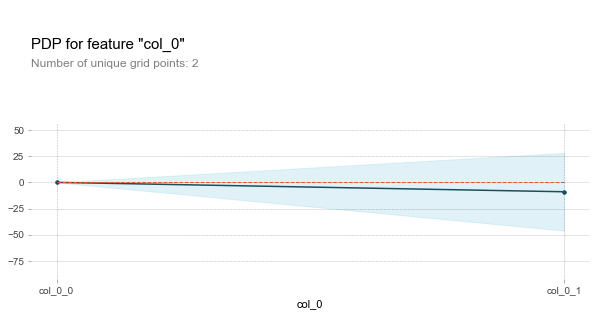

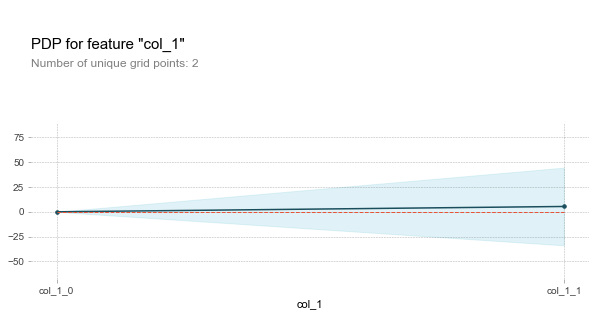

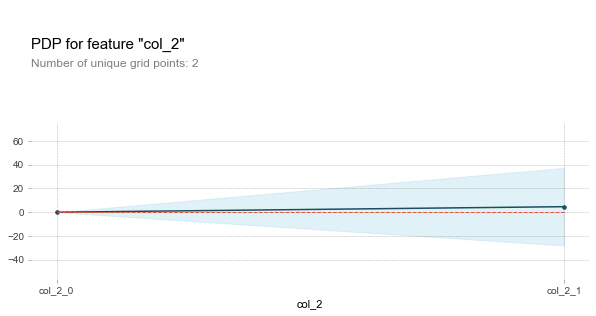

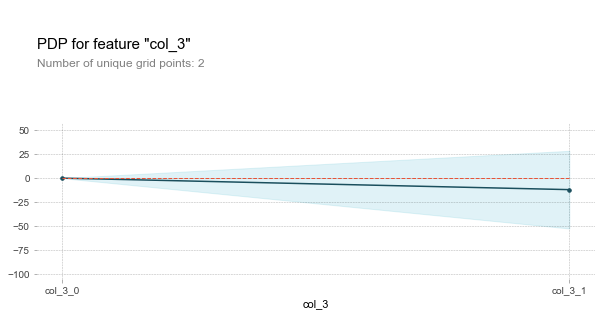

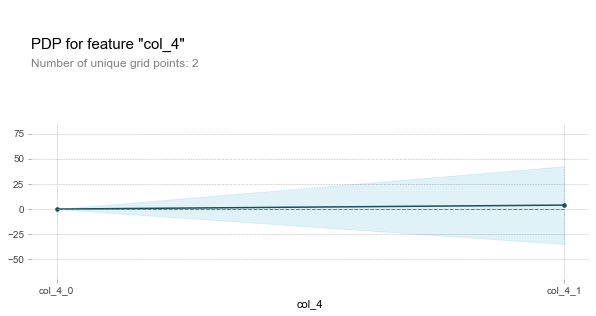

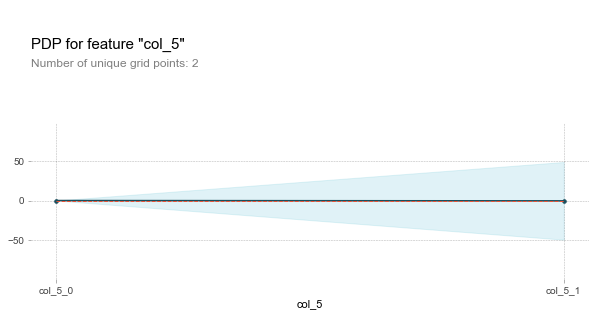

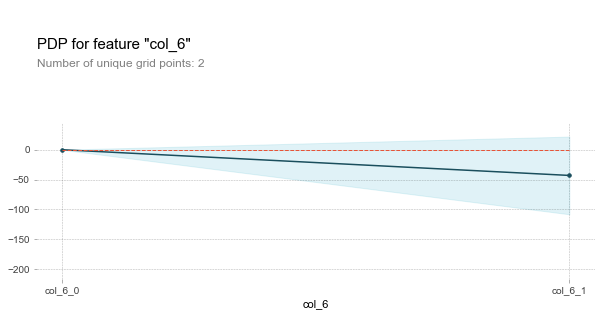

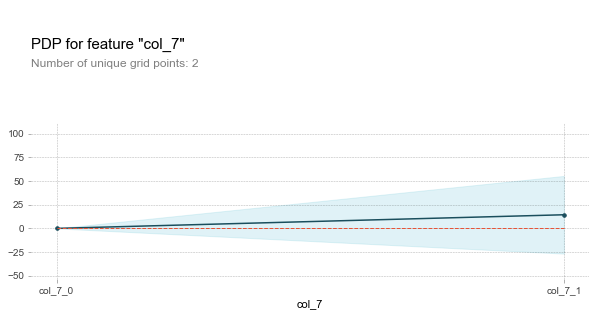

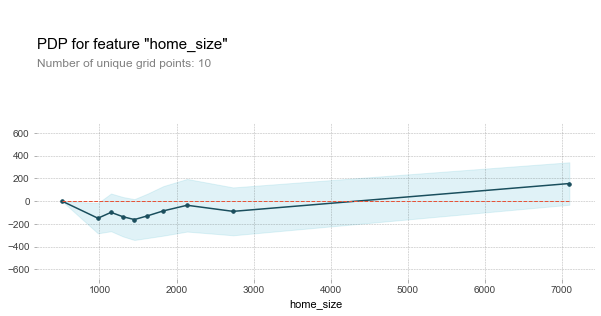

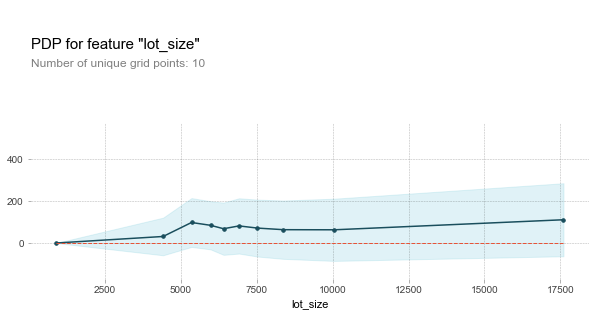

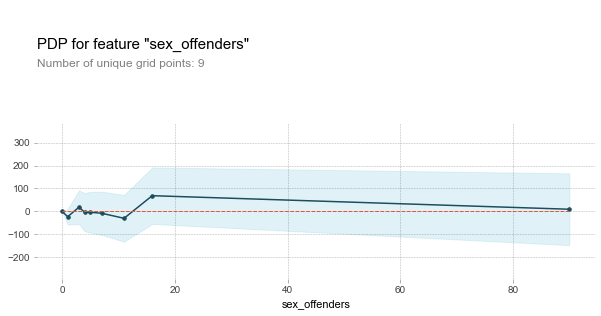

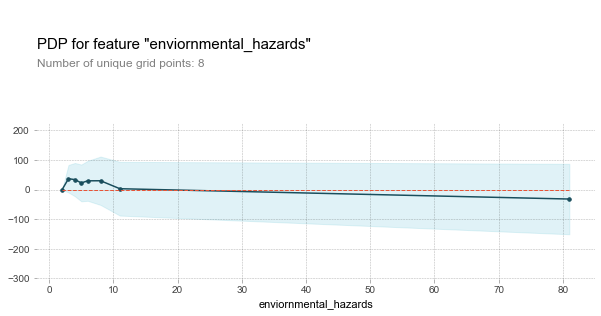

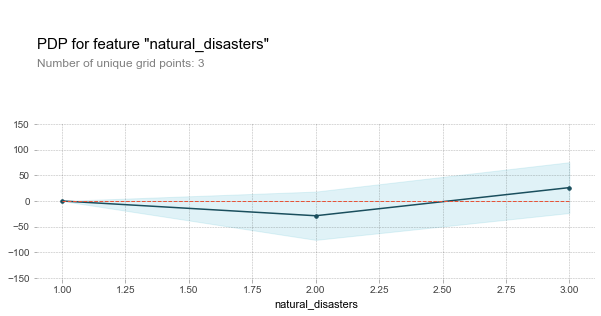

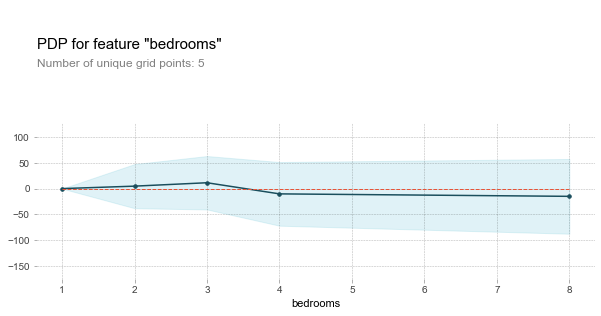

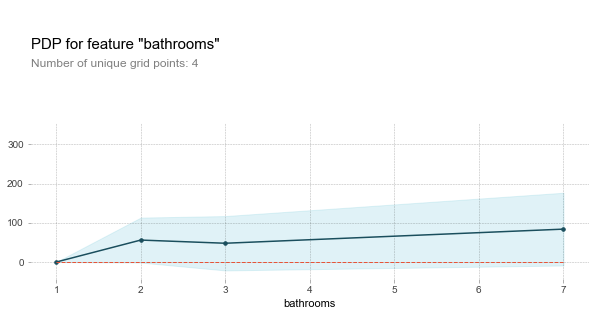

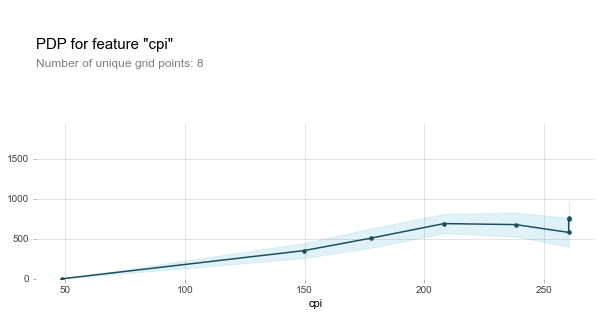

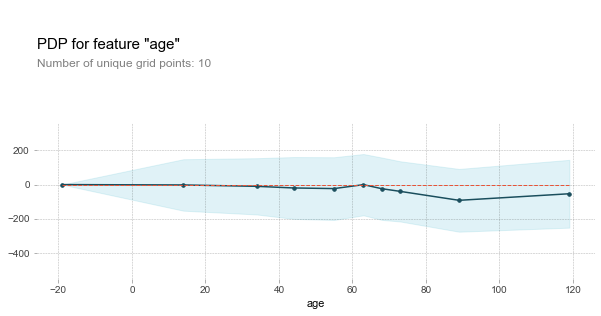

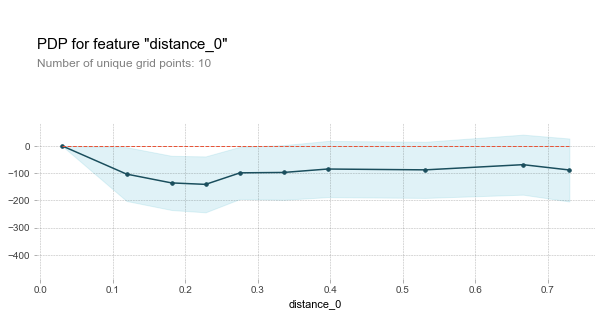

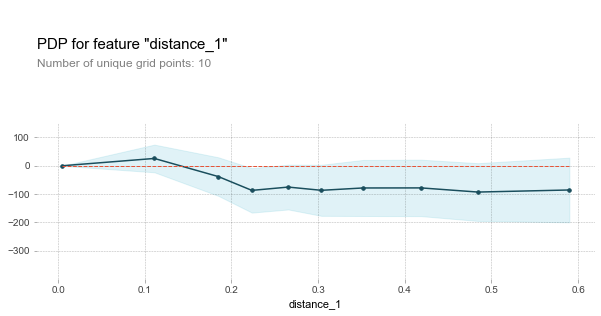

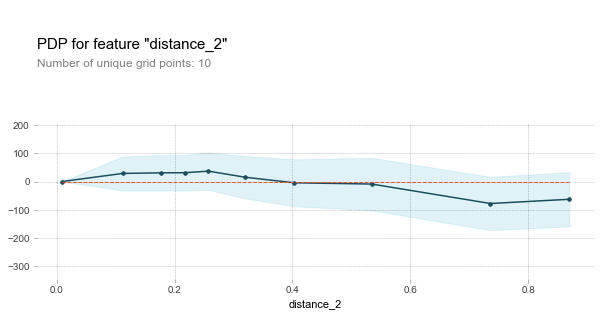

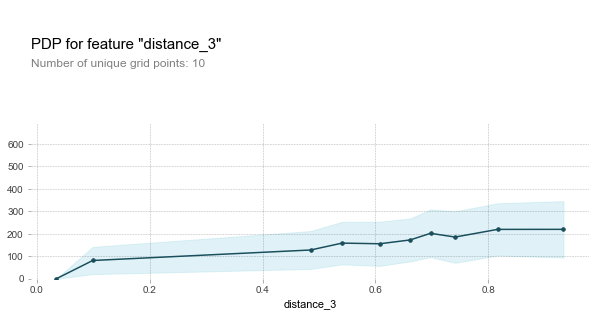

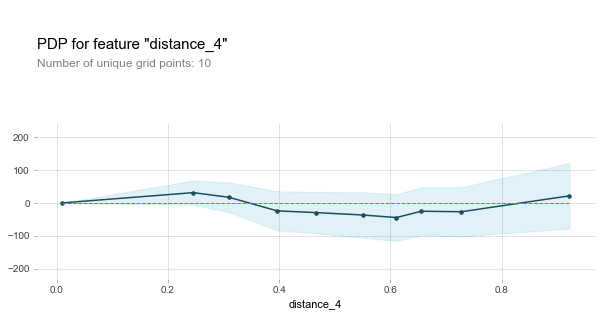

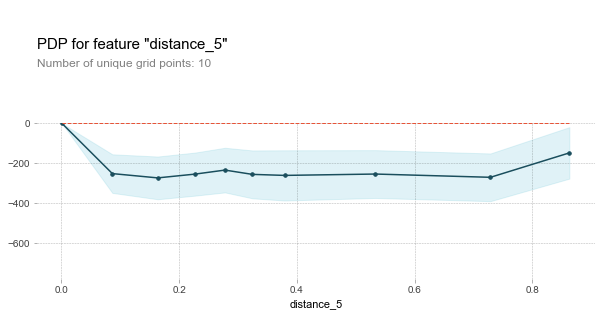

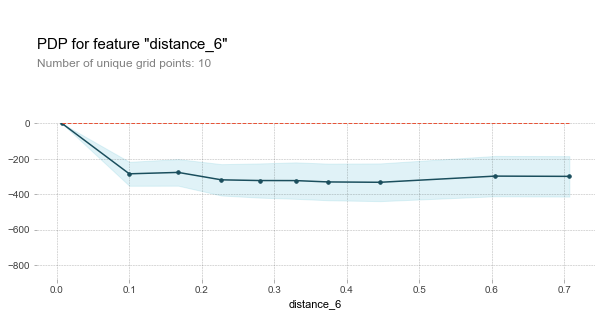

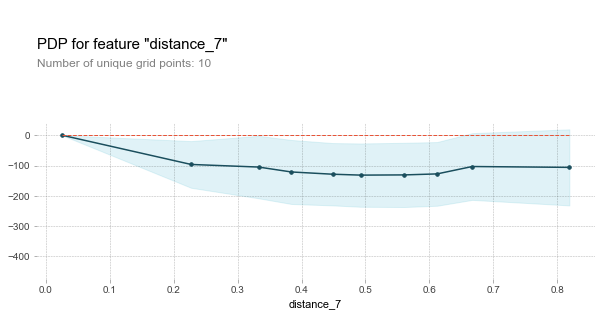

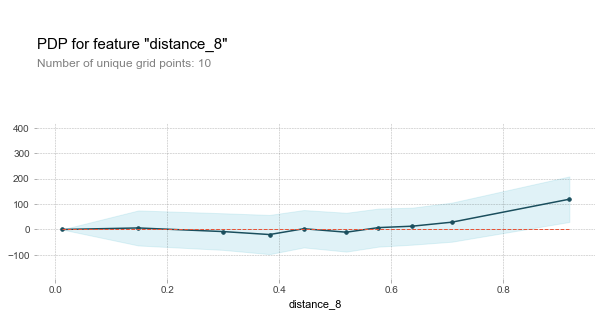

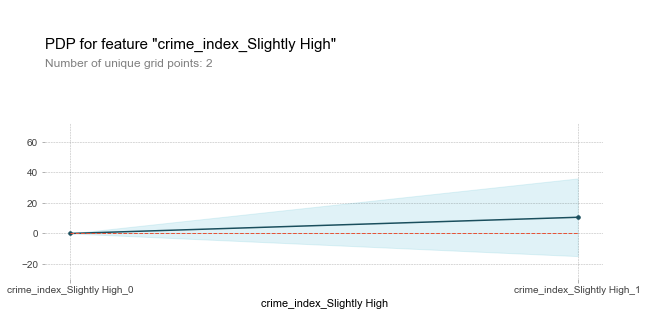

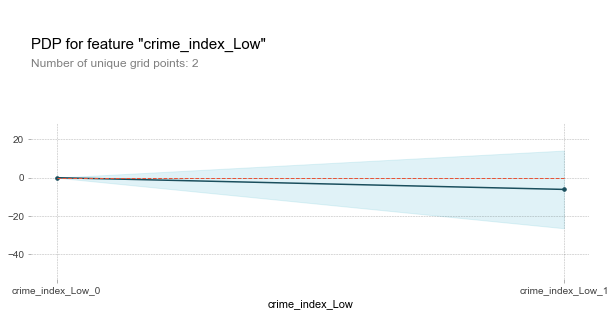

In [ ]:
from pdpbox import pdp

for col in x_train.columns:    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=regressor, dataset=pd.DataFrame(x_test), model_features=x_test.columns, feature=col)

    # plot it
    pdp.pdp_plot(pdp_goals, col, figsize=(10,5))
    plt.show()

### Random Forest Model

In [20]:
#Optimize the objective function with hyperopt for xgboost

#Definte the search spaces
space = {
        
            'min_impurity_split' : [None, 1, 2, 3, 4, 5, 6, 7, 8 , 9, 10],
            #'bootstrap' : [True, False],
            'max_features' : ['auto', 'sqrt', 'log2']
         }

#Objective function
#cv = KFold(n_splits=5, random_state=24, shuffle=True)

def acc_model(params):
    
    depth = int(params['max_depth'])
    est= int(params['n_estimators'])
    max_nodes = int(params['max_leaf_nodes'])
    min_leaf = int(params['min_samples_leaf'])
   
    regressor = RandomForestRegressor(
                                      random_state=24,
                                      criterion='mae', 
                                      n_estimators= est, 
                                      max_depth=depth,
                                      max_features=params['max_features'],
                                      min_samples_split=params['min_samples_split'],
                                      min_samples_leaf = min_leaf,
                                      #min_weight_fraction_leaf = params['min_weight_fraction_leaf'],
                                      max_leaf_nodes = max_nodes,
                                      min_impurity_decrease= params['min_impurity_decrease'],
                                      #bootstrap = params['bootstrap']
                                     )
                                      
                                      
                                      
                                      
                                 
    #return -cross_val_score(regressor, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv).mean()

#Define the search space
param_space = {
                'n_estimators': hp.quniform('n_estimators', 10,500,1),
                'max_depth': hp.quniform('max_depth',1,50,1),
                'max_features' : hp.choice('max_features', space.get('max_features')),
                'min_samples_split': hp.quniform('min_samples_split', 1,500,1),
                'min_samples_leaf': hp.uniform('min_samples_leaf',1,150),
                #'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf',1,50),
                'max_leaf_nodes': hp.quniform('max_leaf_nodes',1,1000,1),
                'min_impurity_decrease': hp.uniform('min_impurity_decrease', 1,100),
                #'booststrap': hp.choice('booststrap', space.get('booststrap')),
            }

best = 100

def f(params):
    global best
    acc = acc_model(params)
    if acc < best:
        best = acc
        print ('new best:', best, params) 
        
    return {'loss': acc, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(f, param_space, algo=tpe.suggest, max_evals=2, trials=trials)
print ('best:')
print (best_params)

100%|██████████| 2/2 [58:57<00:00, 1768.57s/trial, best loss: 439.1485655935165]
best:
{'max_depth': 40.0, 'max_features': 2, 'min_samples_leaf': 83.2037437046098, 'n_estimators': 378.0}


In [23]:
#Create a function that can transform the parameters into a readable object for the Random Forest Regressor
def return_proper_params(best):
    temp = best.copy()
    temp['max_depth'] = int(temp['max_depth'])
    temp['n_estimators'] = int(temp['n_estimators'])
    
    for param in space:
        temp[param] = space.get(param)[best.get(param)]
        
    return temp


#best_params = return_proper_params(best_params)

save_obj(best_params, 'best_params_random_forest')
best_params = load_obj('best_params_random_forest')
best_params

{'max_depth': 40.0,
 'max_features': 2,
 'min_samples_leaf': 83.2037437046098,
 'n_estimators': 378.0}

In [30]:
#Write a function that calculates mape
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


regressor = RandomForestRegressor(
                                  random_state=24,
                                  #criterion='mae', 
                                  n_estimators= int(best_params['n_estimators']), 
                                  max_depth= best_params['max_depth'],
                                  max_features=best_params['max_features'],
                                  #min_samples_split= best_params['min_samples_split'], 
                                  min_samples_leaf = int(best_params['min_samples_leaf'])
                                  #min_weight_fraction_leaf = best_params['min_weight_fraction_leaf'],
                                  #max_leaf_nodes = best_params['max_leaf_nodes'],
                                  #min_impurity_decrease= best_params['min_impurity_decrease'],
                                  #booststrap = best_params['booststrap'],
                                 )

regressor.fit(x_train, y_train)

# Use this code when using the power transformer
# Need to back transform the target variable
test_predictions = regressor.predict(x_test)**2
y_test_transformed = y_test**2


score = np.round(mean_absolute_percentage_error(y_test_transformed, test_predictions),3)
print(f'Random Forest mape on testing set: {score}%')

Random Forest mape on testing set: 153.436%


In [29]:
#MAPE for the train set
train_predictions = regressor.predict(x_train)**2
y_train_transformed = y_train**2

score = np.round(mean_absolute_percentage_error(y_train_transformed, train_predictions),3)
print(f'Random Forest mape on training set: {score}%')

Random Forest mape on training set: 148.954%


In [39]:
#Let's examine the residuals
residuals = x_train.copy()
residuals['sale_price'] = y_train_transformed
residuals['predicted_sale_price'] = train_predictions
residuals['residuals'] = y_train_transformed - train_predictions
sorted_df = residuals.sort_values(by='residuals', ascending=False)
sorted_df

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,home_size,lot_size,sex_offenders,enviornmental_hazards,natural_disasters,bedrooms,bathrooms,cpi,age,distance_0,distance_1,distance_2,distance_3,distance_4,distance_5,distance_6,distance_7,distance_8,crime_index_Low,crime_index_Slightly High,crime_index_Moderate,crime_index_Very Low,crime_index_Moderately High,crime_index_High,crime_index_Very High,school_quality_Above Average,school_quality_Poor,school_quality_Average,school_quality_Excellent,sale_price,predicted_sale_price,residuals
574,0,1,0,0,0,0,0,0,1191.00000,4406.00000,36,3,2,2.00000,1.00000,260.40000,113.00000,0.22685,0.63743,0.09936,0.15558,0.27660,0.36690,0.38657,0.47139,0.15189,0,1,0,0,0,0,0,0,1,0,0,7420000.00000,1336455.14765,6083544.85235
406,0,0,0,0,1,0,0,0,1621.00000,6455.00000,4,2,1,3.00000,2.00000,260.30100,64.00000,0.17183,0.72373,0.41514,0.33757,0.07805,0.68366,0.65254,0.21397,0.27773,0,0,1,0,0,0,0,0,0,0,1,7450000.00000,1402940.59270,6047059.40730
2307,0,0,1,0,0,0,0,0,776.00000,5137.00000,7,4,1,2.00000,1.00000,260.30100,82.00000,0.28447,0.51345,0.18893,0.28723,0.22467,0.43395,0.36065,0.38412,0.01812,0,1,0,0,0,0,0,0,0,0,1,7400000.00000,1358370.11280,6041629.88720
189,0,1,0,0,0,0,0,0,1236.00000,6497.00000,6,3,2,3.00000,2.00000,260.30100,66.00000,0.05787,0.84401,0.36937,0.20294,0.23767,0.61768,0.66346,0.41022,0.33679,0,1,0,0,0,0,0,0,0,0,1,7400000.00000,1392506.42944,6007493.57056
5314,0,0,0,0,1,0,0,0,1182.00000,5118.00000,56,63,1,2.00000,1.00000,260.30100,114.00000,0.18050,0.67199,0.14197,0.12360,0.25295,0.40506,0.43405,0.45334,0.16973,0,1,0,0,0,0,0,0,1,0,0,7250000.00000,1257990.95089,5992009.04911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4474,1,0,0,0,0,0,0,0,5961.00000,2265120.00000,0,2,2,5.00000,5.00000,149.70000,2.00000,0.54981,0.76951,0.26785,0.38254,0.63479,0.08724,0.33809,0.82498,0.46832,0,0,1,0,0,0,0,0,0,0,1,255072.00000,2006758.93428,-1751686.93428
5280,0,0,0,0,0,0,1,0,1780.00000,7523.00000,2,2,1,3.00000,3.00000,198.80000,45.00000,0.59783,0.68465,0.28436,0.44713,0.64980,0.02787,0.24205,0.82660,0.46092,0,0,0,1,0,0,0,0,0,0,1,83000.00000,1835584.18144,-1752584.18144
4794,0,0,0,0,0,1,0,0,4416.00000,17498.00000,0,4,2,4.00000,6.00000,161.60000,-1.00000,0.57317,0.52091,0.25672,0.46075,0.57450,0.17801,0.08275,0.72765,0.36841,1,0,0,0,0,0,0,0,0,0,1,135000.00000,1993019.12661,-1858019.12661
464,0,0,0,0,0,0,0,1,12402.00000,5706360.00000,0,2,1,5.00000,7.00000,149.50000,-15.00000,0.60237,0.70543,0.29272,0.44791,0.66018,0.02464,0.26283,0.83928,0.47413,0,0,0,1,0,0,0,1,0,0,0,160000.00000,2046474.57513,-1886474.57513


## Extra tools

In [38]:
np.count_nonzero(np.unique(train_predictions))

6492

In [119]:
def diagnostic_plots(df, variable, labels):
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    df[variable].hist()
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,2)
    stats.probplot(df[variable], dist='norm', plot=pylab)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')
    
    plt.subplot(1,3,3)
    plt.scatter(df[variable], labels)
    plt.title(col)
    plt.ticklabel_format(style='plain', axis='x')

In [154]:
#This function helps determine which variables are correlated

def correlation(dataset, threshold):
    
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            # we are interested in absolute coeff value
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    
    return col_corr


corr_features = correlation(x_train, 0.8)
print('correlated features: ', len(set(corr_features)))
print(corr_features)

correlated features:  2
